In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as signal
import pandas as pd

import obspy
import obspy.signal.trigger as trigger
from obspy import taup, geodetics

## setting client
from obspy.clients.fdsn import Client
client = Client("IRIS")

## Getting all events

In [2]:
## retrieveing events within an area\n",
starttime = obspy.UTCDateTime("2020-09-01T00:00:00")
endtime = obspy.UTCDateTime("2020-09-10T00:00:00")

cat0 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=0, 
                         latitude=63.98,longitude=-143.99, maxradius=4)
cat1 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=1, 
                         latitude=63.98,longitude=-143.99, minradius = 4, maxradius=8)
cat2 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=2, 
                         latitude=63.98,longitude=-143.99, minradius = 8, maxradius=20)
cat3 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=3, 
                         latitude=63.98,longitude=-143.99, minradius = 20, maxradius=100)
cat4 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=4, 
                         latitude=63.98,longitude=-143.99, minradius = 100, maxradius=180)
cat_all = cat1 + cat2 + cat3 + cat4 + cat0

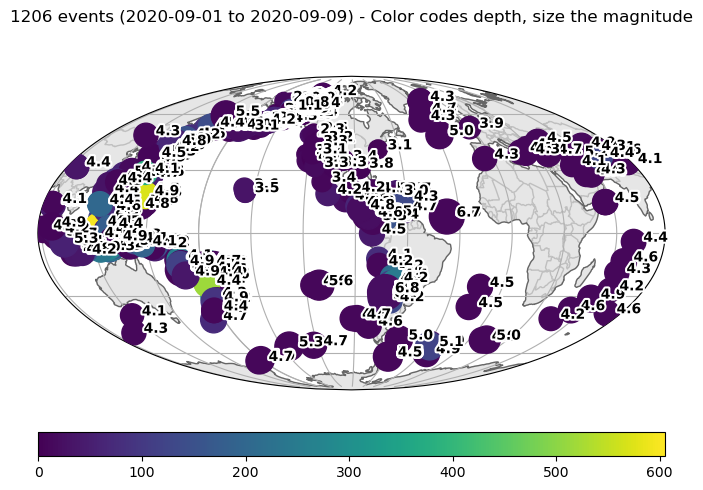

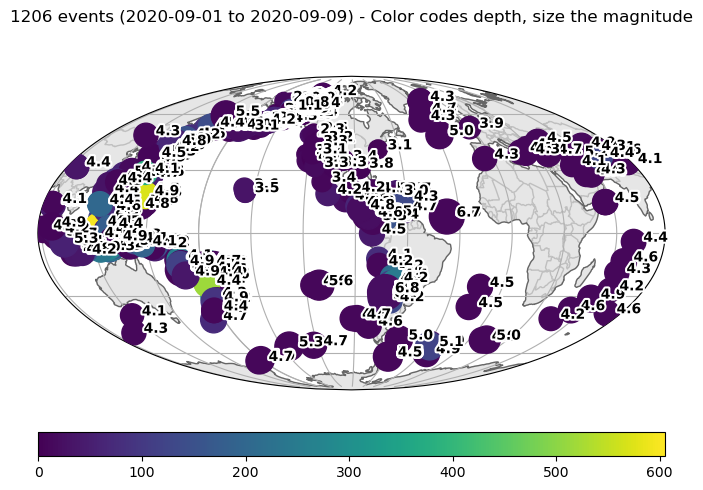

In [3]:
# cattest = client.get_events(starttime=starttime, endtime="2021-09-10T00:00:00", minmagnitude=7, 
#                          latitude=63.98,longitude=-143.99, minradius = 0, maxradius=180)
# cattest.plot()
cat_all.plot()

In [4]:
## getting 10 day data from SCRK station\n",
## get SCRK station
inventory = client.get_stations(network="AK", station="SCRK")
SCRK_station = inventory[0].stations[0]

SCRK_stream = client.get_waveforms("AK", "SCRK", "*", "BHZ", starttime=starttime, endtime=endtime)
st = SCRK_stream.merge(method=0,fill_value=0).detrend().filter("bandpass", freqmin=0.5, freqmax=24)
#st.plot()

### Picking using STA/LTA

In [5]:
trace = st[0]
trace_times = trace.times()
# trace_times = trace.stats.starttime + trace_times                 ## don't use for large datasets

fs = trace.stats.sampling_rate
cft = trigger.recursive_sta_lta(trace.data, int(5 * fs), int(10 * fs))
# trigger.plot_trigger(trace, cft, 1.2, 0.5)

## defione threshold above which to trigger (value from Tian et al.)
cft_threshold = 1.35

## define time offsets from theoretical arrival time within which to check for peak (value from Tian eta l.)
minsample_offset = int(10/trace.stats.delta)     ## search starting 10 s before
maxsample_offset = int(30/trace.stats.delta)     ## search till 30 s after

### Empty lists and datafram for catalog to dataframe conversion

In [6]:
sourcetime = []
arrivaltime = []
lat = []
lon = []
dep = []
magnitude = []
magnitude_type = []
event_type = []

In [7]:
## intitalize a model using taup
model = taup.TauPyModel(model="prem")

cat_select = []

for event in cat_all:
    if len(event.origins) != 0 and len(event.magnitudes) != 0:
        station_event_dist_deg = geodetics.base.kilometers2degrees(geodetics.locations2degrees(event.origins[0].latitude, event.origins[0].longitude, SCRK_station.latitude, SCRK_station.longitude))
        model = obspy.taup.TauPyModel(model="prem")
        travel_time = model.get_travel_times(source_depth_in_km=max(0.0, event.origins[0].depth*1e-3), distance_in_degree=station_event_dist_deg)
        arrival_time_utc = event.origins[0].time + travel_time[0].time 
        arrival_time_relative = arrival_time_utc - trace.stats.starttime

        closest_stream_sample = np.absolute(trace_times-arrival_time_relative).argmin()
        search_range = range(closest_stream_sample - minsample_offset, closest_stream_sample + maxsample_offset)
        if np.max(cft[search_range]) >= cft_threshold:
            sourcetime.append(event.origins[0].time)
            lat.append(event.origins[0].latitude)  
            lon.append(event.origins[0].longitude)
            dep.append(event.origins[0].depth)
            magnitude.append(event.magnitudes[0].mag)
            magnitude_type.append(event.magnitudes[0].magnitude_type )
            event_type.append(event.event_type)
            arrivaltime.append(arrival_time_utc)

In [8]:
catalog_df = pd.DataFrame({'Latitude':lat,'Londitude':lon,'Depth':dep,
                    'Magnitude':magnitude,'Magnitude_type':magnitude_type, 
                    'Event_type': event_type, 'SourceTime': sourcetime, 'SCRKarrivaltime': arrivaltime})

array([[<AxesSubplot:title={'center':'Magnitude'}>]], dtype=object)

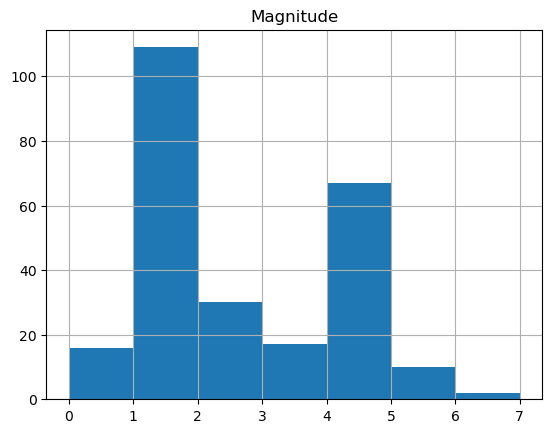

In [9]:
catalog_df.hist(column="Magnitude", bins = [0,1,2,3,4,5,6,7])

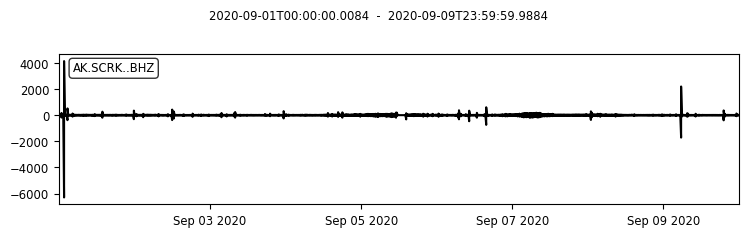

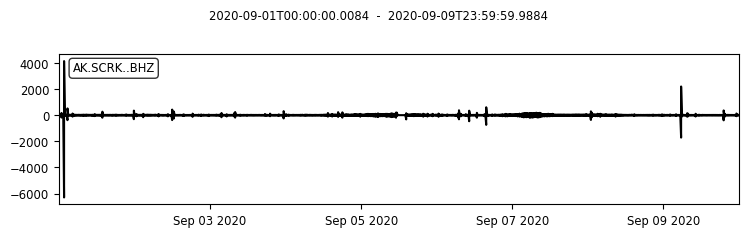

In [10]:
st.plot()

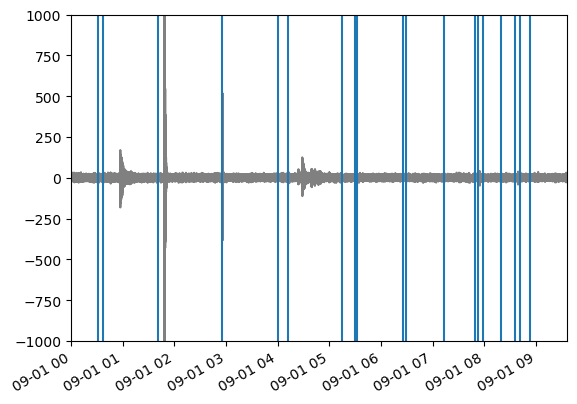

In [19]:
arr_time = np.array(catalog_df.SCRKarrivaltime)
tr = st[0]
fig, ax = plt.subplots(1, 1)
ax.plot(tr.times("matplotlib"), tr.data, "grey")
ax.xaxis_date()
ax.vlines(arr_time, ymin = -1000, ymax = 1000)
ax.set_xlim(18506, 18506.4)
ax.set_ylim(-1000, 1000)
fig.autofmt_xdate()
plt.show()

In [119]:
tr_trunc = tr.slice(starttime = obspy.UTCDateTime("2020-09-06T12:34:58.719000Z"), endtime =  obspy.UTCDateTime("2020-09-06T12:34:58.719000Z")+600)
tr_trunc1 = tr.slice(starttime = obspy.UTCDateTime("2020-09-06T12:34:58.719000Z")+600, endtime =  obspy.UTCDateTime("2020-09-06T12:34:58.719000Z")+1200)

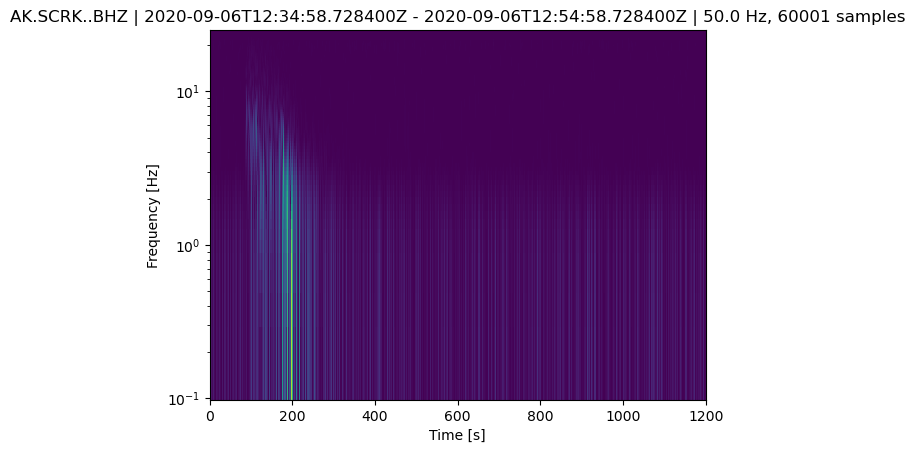

In [66]:
tr_trunc.spectrogram(log=True)

In [106]:
tr_trunc.spectrogram?

Signature: tr_trunc.spectrogram(**kwargs)
Docstring:
Create a spectrogram plot of the trace.

For details on kwargs that can be used to customize the spectrogram
plot see :func:`~obspy.imaging.spectrogram.spectrogram`.

.. rubric:: Example

>>> from obspy import read
>>> st = read()
>>> tr = st[0]
>>> tr.spectrogram()  # doctest: +SKIP

.. plot::

    from obspy import read
    st = read()
    tr = st[0]
    tr.spectrogram()
File:      ~/anaconda3/envs/seis/lib/python3.9/site-packages/obspy/core/trace.py
Type:      method


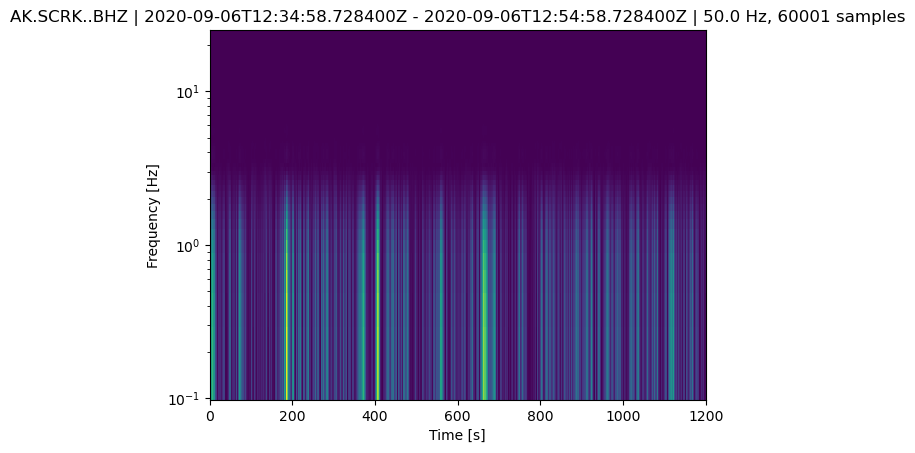

In [102]:
tr_filt = tr_trunc.copy()
tr_filt.filter('lowpass', freq=0.1)
tr_filt.spectrogram(log=True)

In [88]:
print(catalog_df.loc[(catalog_df['Magnitude'] > 3) & (catalog_df['Latitude'] > 55)])

     Latitude  Londitude     Depth  Magnitude Magnitude_type  Event_type  \
20    58.0990  -154.5705   83100.0        3.2             ML  earthquake   
22    59.3466  -152.0721   55000.0        3.7             ml  earthquake   
47    60.0249  -153.3391  132600.0        3.5             ML  earthquake   
133   67.9870   -18.6094   10000.0        4.3             mb  earthquake   

                      SourceTime              SCRKarrivaltime  
20   2020-09-07T18:02:54.500000Z  2020-09-07T18:03:05.769439Z  
22   2020-09-06T12:34:58.719000Z  2020-09-06T12:35:06.509329Z  
47   2020-09-02T18:25:50.005000Z  2020-09-02T18:26:07.385101Z  
133  2020-09-03T04:15:58.527000Z  2020-09-03T04:16:06.040702Z  


In [70]:
data = tr_trunc.data
DATA = np.fft.fftshift(np.fft.fft(data, len(data)))
freq = np.fft.fftshift(np.fft.fftfreq(len(data), tr_trunc.stats.delta))

In [104]:
data1 = tr_filt.data
DATA1 = np.fft.fftshift(np.fft.fft(data1, len(data1)))
freq1 = np.fft.fftshift(np.fft.fftfreq(len(data1), tr_filt.stats.delta))

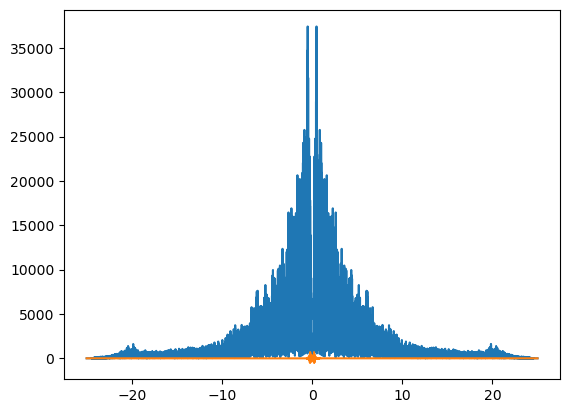

In [107]:
fig, ax = plt.subplots(1,1)
ax.plot(freq, np.abs(DATA))
ax.plot(freq1, DATA1)
plt.show()

In [112]:
import scipy.signal

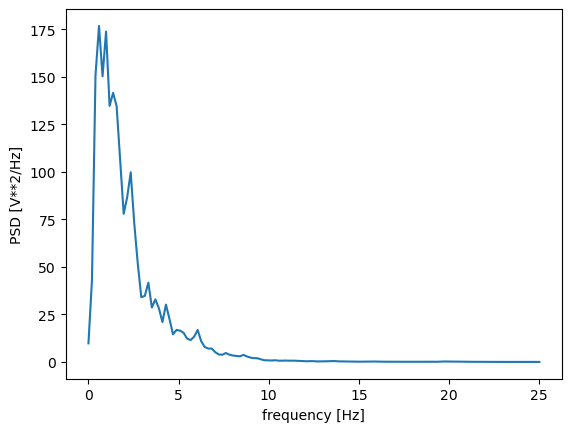

In [123]:
f, Pxx_den =  scipy.signal.welch(tr_trunc.data, fs = 1/tr_trunc.stats.delta)
plt.plot(f, Pxx_den)

# plt.xlim/([0,5])

plt.xlabel('frequency [Hz]')

plt.ylabel('PSD [V**2/Hz]')

plt.show()

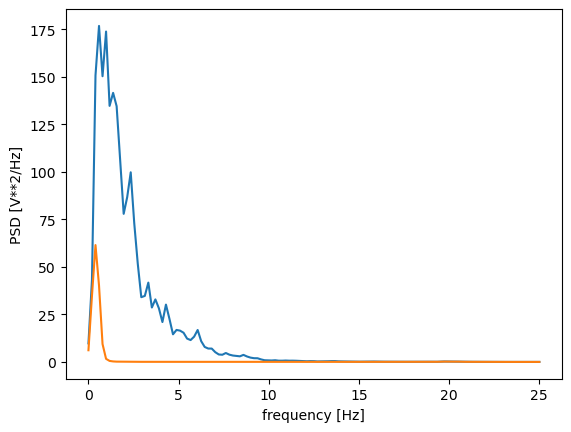

In [124]:
f1, Pxx_den1 =  scipy.signal.welch(tr_trunc1.data, fs = 1/tr_trunc.stats.delta)
plt.plot(f, Pxx_den)
plt.plot(f1, Pxx_den1)

# plt.xlim/([0,5])

plt.xlabel('frequency [Hz]')

plt.ylabel('PSD [V**2/Hz]')

plt.show()